In [1]:
import os 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow .keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
imdb_df = pd.read_csv('IMDB Dataset.csv')

In [3]:
imdb_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
imdb_df.shape

(50000, 2)

In [5]:
imdb_df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [6]:
missing_values = imdb_df.isnull().sum()
missing_values

review       0
sentiment    0
dtype: int64

In [7]:
imdb_df.dtypes

review       object
sentiment    object
dtype: object

In [8]:
imdb_df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [9]:
def clean_review(review):
    review = re.sub(r'<.*?>', '', review)
    review = review.lower()
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    return review

In [10]:
imdb_df['cleaned_review'] = imdb_df['review'].apply(clean_review)

In [11]:
imdb_df[['cleaned_review']].head()

,cleaned_review
0,one of the other reviewers has mentioned that ...
1,a wonderful little production the filming tech...
2,i thought this was a wonderful way to spend ti...
3,basically theres a family where a little boy j...
4,petter matteis love in the time of money is a ...


C:\Users\DELL\AppData\Local\Temp\ipykernel_11000\1100368566.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=imdb_df, palette='viridis')


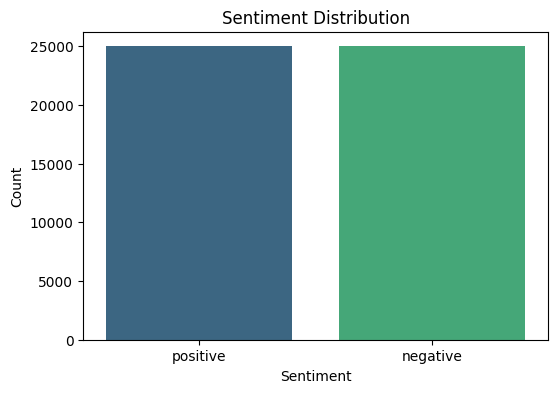

In [12]:
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=imdb_df, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

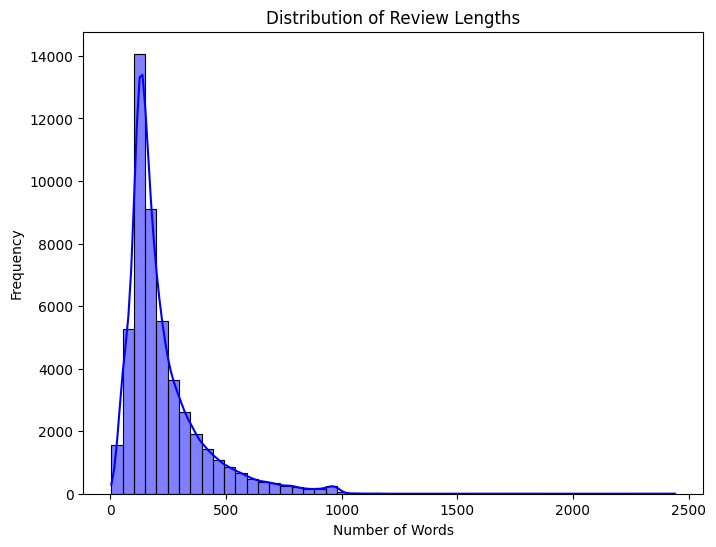

In [13]:
review_lengths = imdb_df['cleaned_review'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 6))
sns.histplot(review_lengths, bins=50, kde=True, color='blue')
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [14]:
max_words = 10000  # Maximum number of words to keep, based on word frequency
max_len = 100  # Maximum sequence length
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(imdb_df['cleaned_review'])
sequences = tokenizer.texts_to_sequences(imdb_df['cleaned_review'])
padded_sequences = pad_sequences(sequences, maxlen=max_len)
padded_sequences.shape

(50000, 100)

In [15]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(imdb_df['sentiment'])
encoded_labels[:5]

array([1, 1, 1, 0, 1])

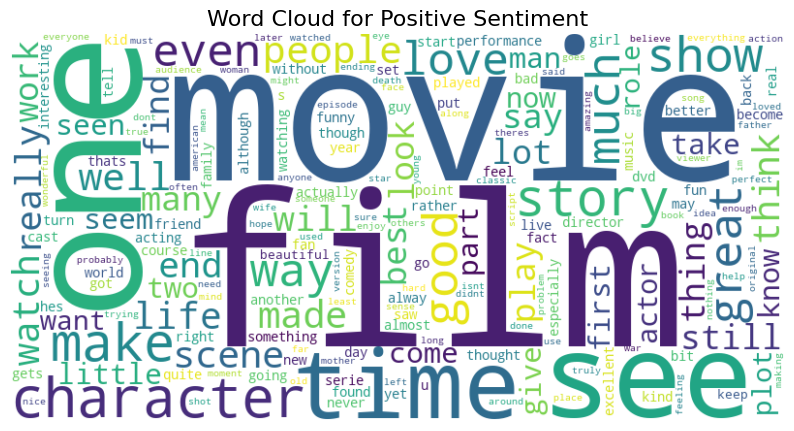

In [16]:
positive_reviews = ' '.join(imdb_df[imdb_df['sentiment'] == 'positive']['cleaned_review'])
positive_wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(positive_reviews)
plt.figure(figsize=(10, 6))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment', fontsize=16)
plt.show()

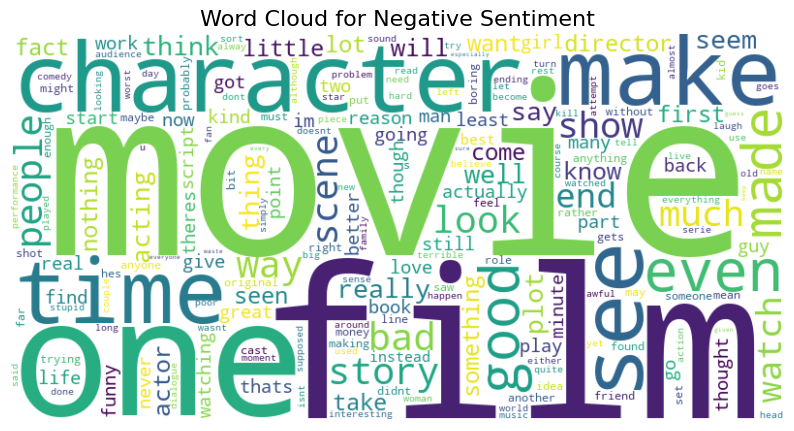

In [17]:
negative_reviews = ' '.join(imdb_df[imdb_df['sentiment'] == 'negative']['cleaned_review'])
negative_wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(negative_reviews)
plt.figure(figsize=(10, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Sentiment', fontsize=16)
plt.show()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)

In [19]:
X_train_df = pd.DataFrame(X_train[:5])
X_train_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1199,5,1,305,139,2465,2,402,271,6,...,2546,5,565,8,35,1,3907,208,342,3808
1,107,22,153,81,21,67,14,1,99,4502,...,95,24,73,1691,17,8,201,88,102,8
2,0,0,0,0,0,0,0,0,0,0,...,1,1452,11,404,86,3,301,2,734,65
3,59,915,7,45,1907,954,1128,3,3496,60,...,14,60,3109,3471,66,31,92,408,319,3427
4,6,133,9,1099,11,8370,1273,24,210,5,...,71,234,340,45,164,547,7,8370,16,250


In [20]:
X_test_df = pd.DataFrame(X_test[:5])
X_test_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,374,268,1536,39,36,167,1030,6,7,6,...,346,2,8,42,3,374,271,198,8,970
1,777,501,13,22,2,1867,7,103,751,19,...,3,5133,102,1,1872,2,63,46,9,9023
2,3289,1,87,61,80,145,6,1,218,2082,...,561,4,99,26,950,7,23,49,1052,89
3,0,0,0,0,0,0,0,0,0,0,...,768,1967,1,1524,1347,146,52,24,97,1141
4,1,220,112,33,408,2821,2,316,4399,1189,...,202,100,519,1040,9,88,101,8,12,70


In [21]:
embedding_dim = 100
lstm_units = 128
# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim))  # Removed input_length parameter
model.add(LSTM(lstm_units, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 102s 157ms/step - accuracy: 0.7267 - loss: 0.5084 - val_accuracy: 0.8496 - val_loss: 0.3537
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 125s 201ms/step - accuracy: 0.8905 - loss: 0.2810 - val_accuracy: 0.8582 - val_loss: 0.3285
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 101s 162ms/step - accuracy: 0.9216 - loss: 0.2091 - val_accuracy: 0.8607 - val_loss: 0.3357
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 98s 156ms/step - accuracy: 0.9392 - loss: 0.1649 - val_accuracy: 0.8581 - val_loss: 0.4104
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 97s 155ms/step - accuracy: 0.9562 - loss: 0.1210 - val_accuracy: 0.8513 - val_loss: 0.4226


In [22]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.8514 - loss: 0.4121
Test Accuracy: 0.8513000011444092


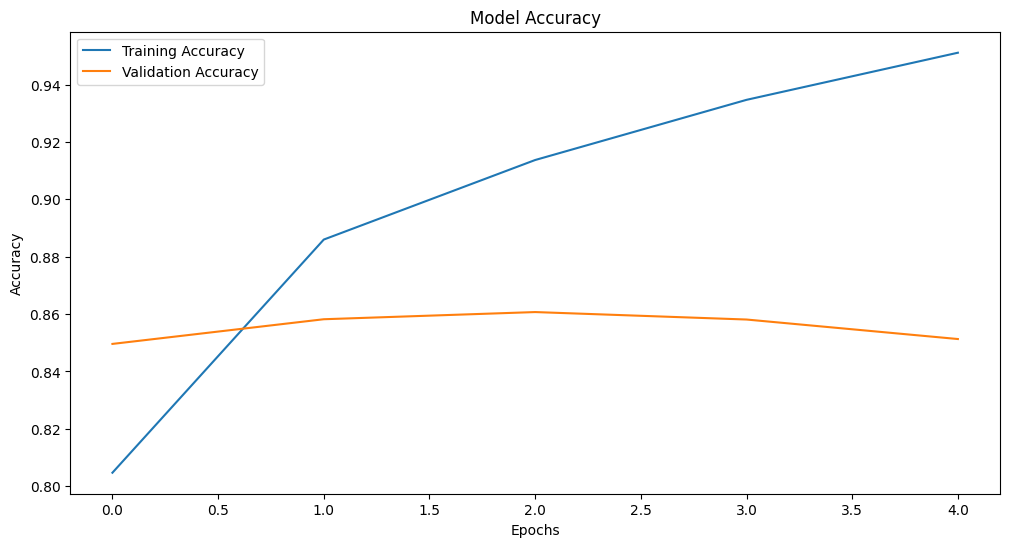

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

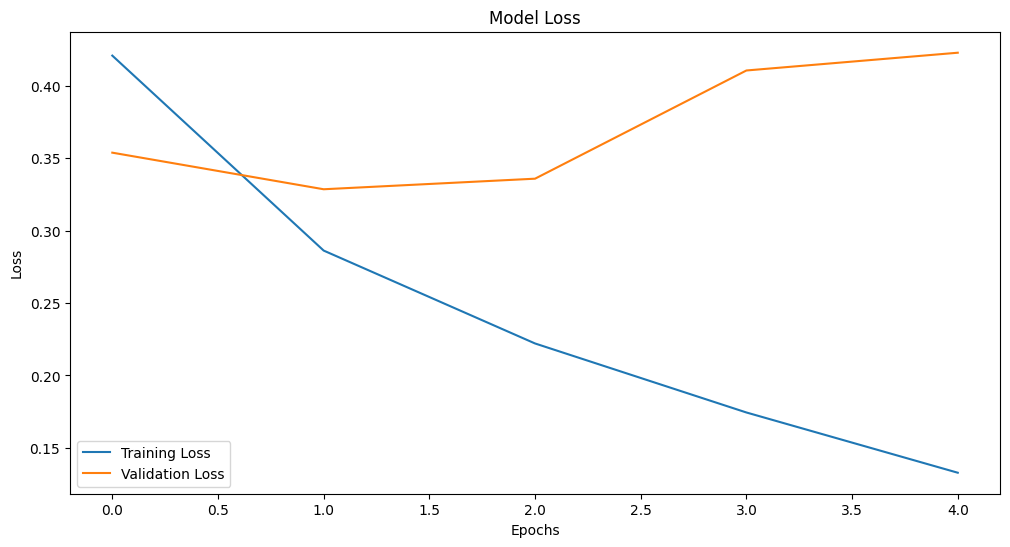

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step


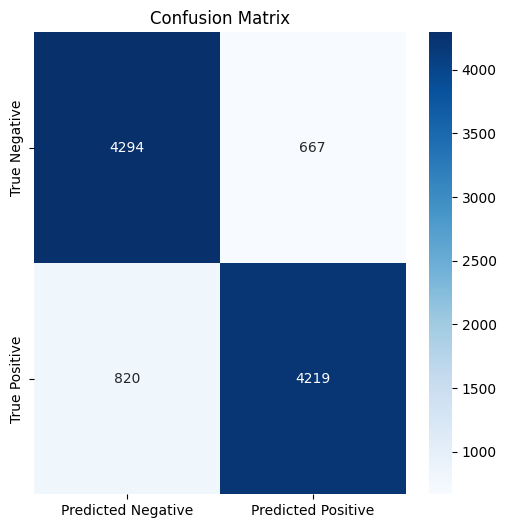

In [25]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Define labels for the axes
labels = ['True Negative', 'True Positive']
predicted_labels = ['Predicted Negative', 'Predicted Positive']
# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=predicted_labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.show()

In [26]:
# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (64, 100, 100)         │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (64, 128)              │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (64, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (64, 1)                │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,352,133 (12.79 MB)

 Trainable params: 1,117,377 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,234,756 (8.52 MB)